# Audit
by David Vicente Martínez & Daniel Loscos Barroso

## 1. Bulding the dataset

The first thing we found out about the database was that the data and the headers where stored in two different files, we merged them in to the file called "o-database".

The dataset consisted of different mushrooms classified as edible or poisonous and their characteristics. 8124 instances were recorded each with information about 22 attributes, all of them nominally valued. Across the database 2480 attribute values where missing, all of them in the "stalk-root" category and labeled "?".

In [1]:
from __future__ import print_function
import pandas as pd
import scipy.stats 
import matplotlib.pyplot as plt
pd.__version__

mushroom_dataframe = pd.read_csv("o-database", sep=",")
mushroom_dataframe.describe()


,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-bellow-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


## 2. Visualizing the data
The first thing we do is plot the data to get a better idea of what we are working with. This task is easy due to the low cardinality of the categorical atribbutes of this dataset.

C:\Users\david\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


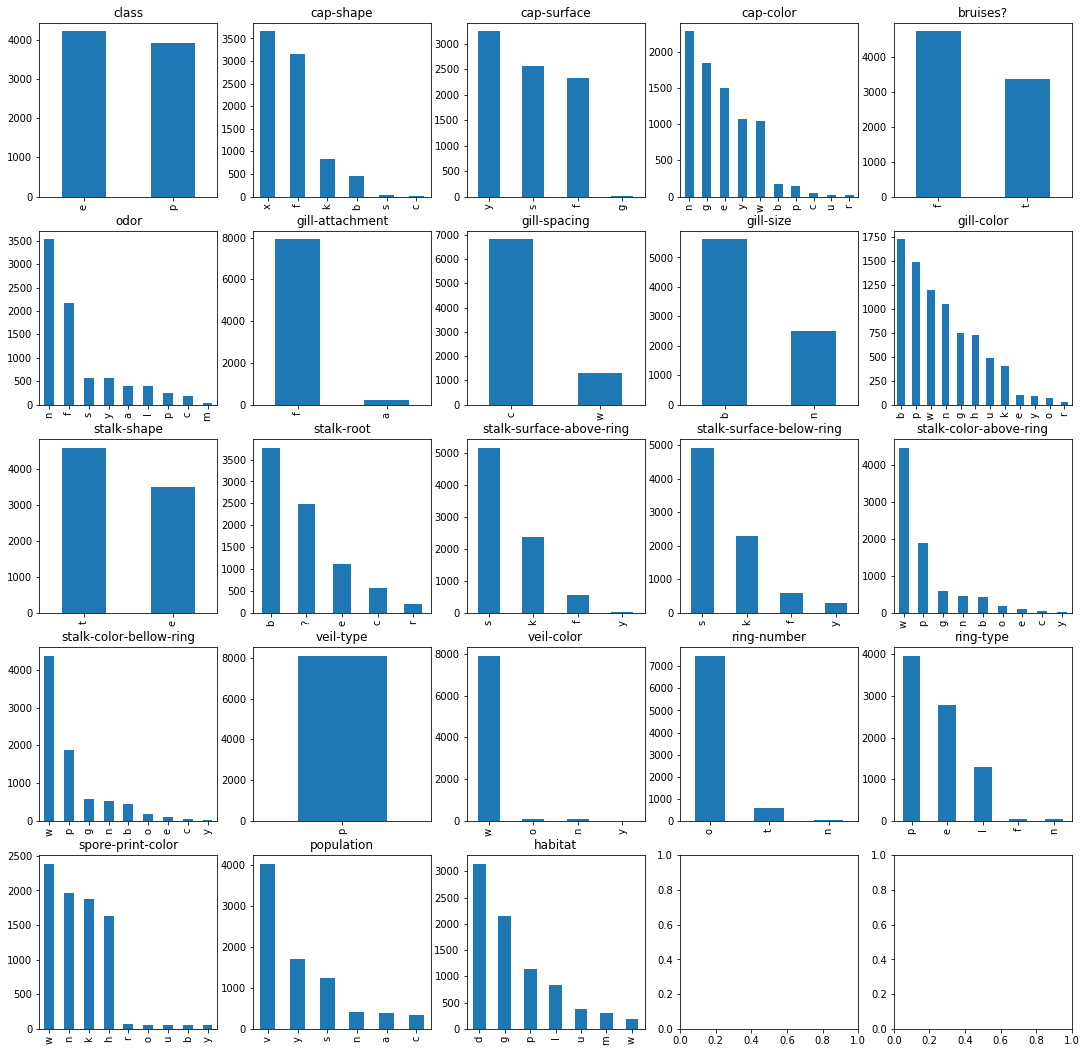

In [2]:
fig, ax = plt.subplots(5,5)
i = 0
for att in mushroom_dataframe.columns.values:
    mushroom_dataframe[att].value_counts().plot(kind = 'bar', ax=ax[i//5][i%5]).set_title(att)
    i = i+1
fig.set_size_inches(18.5, 18.5, forward=True)
fig.show()

In [3]:
print("Entropy values per category:\n")
for att in mushroom_dataframe.columns:
    p_data = mushroom_dataframe[att].value_counts()           # counts occurrence of each value
    entropy = scipy.stats.entropy(p_data)
    print(str(att),": ",entropy)

Entropy values per category:

class :  0.6925010959051001
cap-shape :  1.1456952882318043
cap-surface :  1.0920439563177975
cap-color :  1.739898319287061
bruises? :  0.6788179870650406
odor :  1.6076955835943614
gill-attachment :  0.12000380459019121
gill-spacing :  0.44214360061605323
gill-size :  0.6184649299084096
gill-color :  2.100536009263145
stalk-shape :  0.6840858746320861
stalk-root :  1.2635529897725302
stalk-surface-above-ring :  0.8465738615796716
stalk-surface-below-ring :  0.9698061739607755
stalk-color-above-ring :  1.3424935885255416
stalk-color-bellow-ring :  1.3711580732536597
veil-type :  0.0
veil-color :  0.1360220215864651
ring-number :  0.2915932566642182
ring-type :  1.064065115923805
spore-print-color :  1.5271607522805761
population :  1.3886497900291173
habitat :  1.5767346085798768


The first conclusion from the description of the dataset is tha the attribute "veil-type" has a constant value all across the dataset, therefor providing no information. We decided to remove it.

We can also see that "stalk-root" has missing values. Due to the number of missing values and the graphic showed above those missing values are probably one of the other two attributes that does not appear (cup = u or rhizomorphs = z) or maybe both of them. We do not know how to assign those missing values and removing them or leaving them may cause problems. So, because we already have enough attributes we have decided to discard this one also.

In [4]:
mushroom_dataframe = mushroom_dataframe.drop(columns=['veil-type'])
mushroom_dataframe = mushroom_dataframe.drop(columns=['stalk-root'])
mushroom_dataframe.describe()

,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-bellow-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,4,9,9,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,s,w,w,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,5176,4936,4464,4384,7924,7488,3968,2388,4040,3148


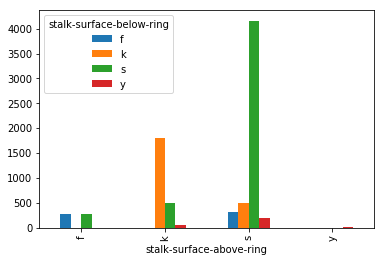

In [5]:
pd.crosstab(index = mushroom_dataframe['stalk-surface-above-ring'], columns = mushroom_dataframe['stalk-surface-below-ring']).plot(kind = 'bar')

In [6]:
for att in mushroom_dataframe.columns:
    for elem in mushroom_dataframe[att].unique():
        mushroom_dataframe[att + "_" + str(elem)] = mushroom_dataframe[att] == elem
mushroom_dataframe.describe()

,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,population_v,population_y,population_c,habitat_u,habitat_g,habitat_m,habitat_d,habitat_p,habitat_w,habitat_l
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,2,2,2,2,2,2,2,2,2,2
top,e,x,y,n,f,n,f,c,b,b,...,False,False,False,False,False,False,False,False,False,False
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4084,6412,7784,7756,5976,7832,4976,6980,7932,7292
